In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from dataset import DataSet
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest as IF
%load_ext autoreload
np.random.seed(2) ## keep same shuffled as was trained on 
torch.manual_seed(2)

In [2]:
%autoreload

## load a checkpoint & dataset the network trained on

In [5]:
lcs = utils.get_data('../../datasets/ZTF_g',test_split=0.0,batch_size=2)


found 3408 for band='g'
max time:  1687.1367
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(3087, 1, 1962, 3)
train size: 3087, valid size: 618, test size: 0


In [ ]:
net,optimizer, cp['args'], cp['epoch'], cp['loss'], cp['train_losses'], cp['test_losses']

In [7]:
net, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/final/ZTF_g0.668415367603302.h5', lcs.data_obj)


TypeError: cannot unpack non-iterable NoneType object

In [17]:
# encode full dataset
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net)
#qzs_sub, disc_path_sub = utils.encode(lcs.data_obj['train_loader'], net, device='mps', subsample=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:17<00:00, 71.55it/s]


In [22]:
print(qzs.shape, disc_path.shape)

(2559, 2, 16, 64) (2559, 16, 64)


In [23]:
num_ref_points = 16 #args.num_ref_points
latent_dim = 64     #args.latent_dim
l = len(lcs.dataset)
tr = int(l * 0.9) # train-test split point

## Sample qZ

In [24]:
n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:]).mean(0)

### uncomment USE MEAN OF QZ instead
# zs = qzs[:,0,:,:].reshape(qzs.shape[0],-1)

In [21]:
RS = 20150101
pca = PCA(random_state=RS)

### pcall

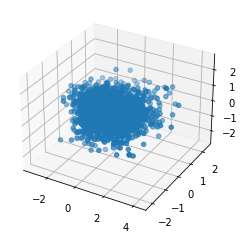

In [85]:
pca3d = pca.fit_transform(zs.reshape(zs.shape[0],-1)) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2])

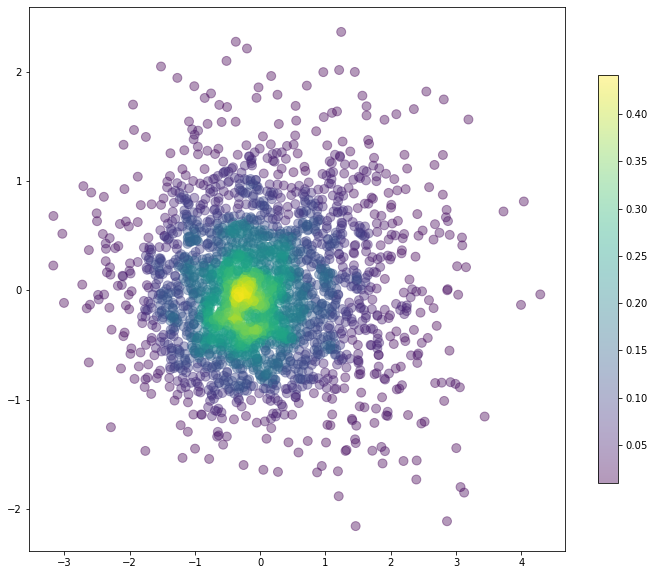

In [86]:
pl = pca3d[:,0:2].T
k = gaussian_kde(pl, bw_method=0.1)(pl)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
dens = ax.scatter(pca3d[:,0],pca3d[:,1],c=k, alpha=0.4,s=80)
fig.colorbar(dens,shrink=0.75)
plt.savefig('../img/pca2d')


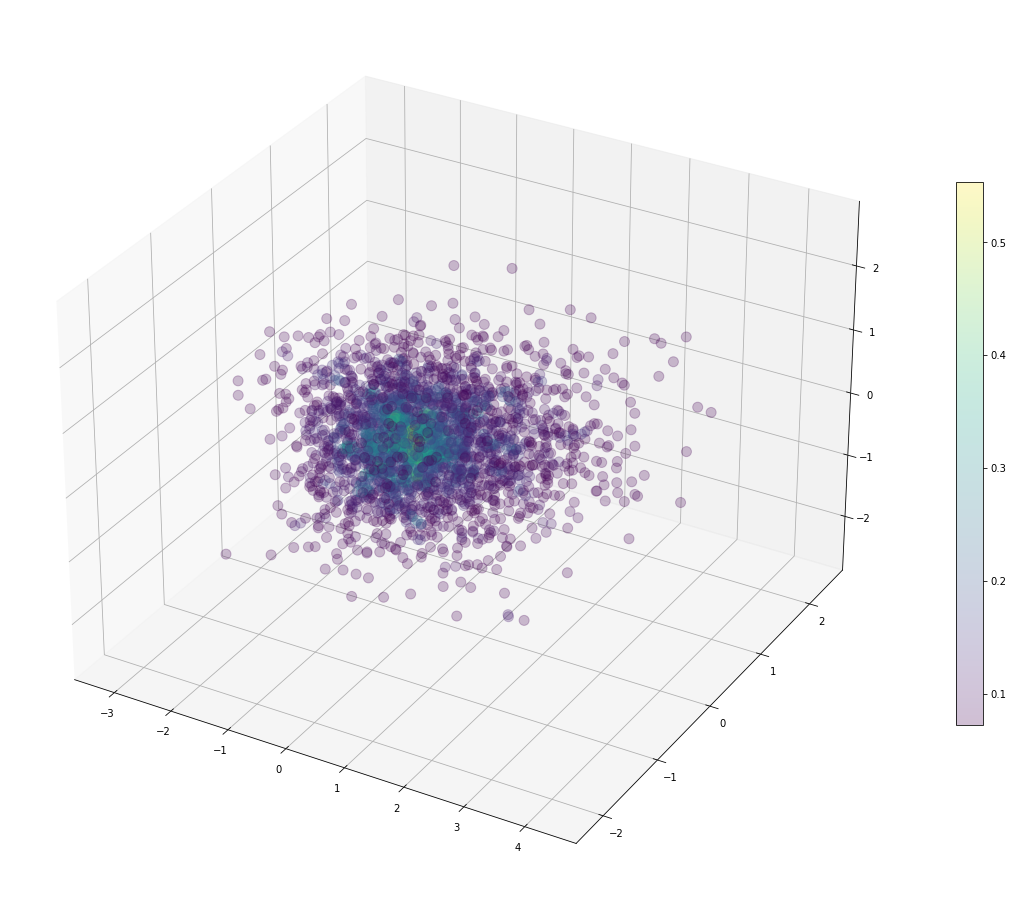

In [87]:
pl = pca3d[:,0:3].T
k = gaussian_kde(pl, bw_method=0.1)(pl)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
dens = ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2],c=k, alpha=0.25,s=100)
fig.colorbar(dens,shrink=0.5)
plt.savefig('../img/pca3d')

## Anonymous Recon

In [9]:
## avg over 10 different fraction subsamples
avg_nlls = np.zeros((10,len(lcs.dataset)))
for i in range(10):
    _,_,nlls = utils.evaluate_hetvae(net, 1, lcs.data_obj['train_loader'], frac=0.5, device='mps', qz_mean=True)
    np.savetxt(f'./nlls_g/nlls_g_{i}',nlls)
    avg_nlls[i] = nlls
    
#avg_nlls = nlls.mean(0)
# std = np.std(nlls)
# mu = np.mean(nlls)
# anom_nlls = (nlls>mu+std) | (nlls<mu-std)


  0%|▋                                                                                                                                                         | 6/1280 [00:19<1:08:55,  3.25s/it]

KeyboardInterrupt



# Isolation Forest

In [54]:
latent = zs.reshape(zs.shape[0],-1) # flatten z

forest = IF(random_state=RS, n_estimators=500,contamination=0.02)
forest.fit(latent)
scores = forest.score_samples(latent)
anom_if_preds = forest.predict(latent)

anom_if_i = anom_if_preds < 0


Text(0.5, 1.0, 'g model anomaly scores from IF')

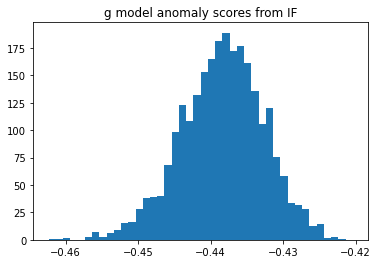

In [65]:
plt.hist(scores,bins=np.arange(np.min(scores),np.max(scores),0.001))
plt.title('g model anomaly scores from IF')
#plt.savefig('../img/g_if_scores')

In [68]:
(scores <= -0.45).sum() / len(lcs.dataset) ### percent based off of our decision boundary

0.026963657678780773

In [71]:
anom_if_i = scores <= -0.45

In [72]:
anom_if_obj_names = np.array(lcs.valid_files_df.index[anom_if_i])

In [73]:
pre_anoms = pd.read_csv('pre_anoms').to_numpy().squeeze()

In [74]:
set(anom_if_obj_names) & set(pre_anoms)

{'001529.81+220615.0',
 '002048.92+260344.9',
 '010030.77+241204.9',
 '030206.77-000121.3',
 '074110.70+311200.2'}

In [ ]:
anoms = anom_IF | anom_nlls

In [ ]:
# save 

## Get normalized excess variance from dataset

In [25]:
np.random.seed(2) ## keep same shuffled as was trained on 
torch.manual_seed(2)

folder = '../../datasets/ZTF_g'

lcs = DataSet(name=folder)
[lcs.add_band(os.path.join(folder, band_folder)) for band_folder in os.listdir(folder)]
lcs.filter()  
lcs.prune_outliers()  
lcs.set_mean_mag()
lcs.set_sigma_nxs()
lcs.set_med_cadence()


validated 3408 files out of 3408 for band='g'


In [26]:
shuffle = np.random.permutation(len(lcs.dataset)) # shuffle so these labels and dataset encodings are aligned 
lcs.sigma_nxs = lcs.sigma_nxs[shuffle]

(array([3.200e+01, 2.177e+03, 2.640e+02, 5.700e+01, 1.800e+01, 5.000e+00,
        1.000e+00, 0.000e+00]),
 array([-0.0001,  0.    ,  0.0001,  0.0002,  0.0003,  0.0004,  0.0005,
         0.0006,  0.0007]),
 <BarContainer object of 8 artists>)

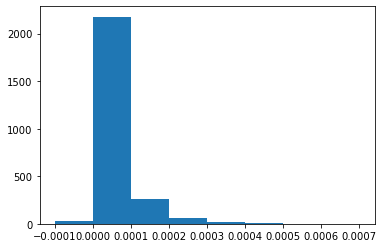

In [27]:
plt.hist(lcs.sigma_nxs, bins=np.arange(-0.0001,0.0008,0.0001))

In [ ]:
## save dataset before its formatted for this reason... 

## Set Up

##### labels: lcs.sigma_nxs
##### dataset: zs

In [113]:
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, INPUT_DIM):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(INPUT_DIM, 32),
          nn.ReLU(),
          nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [121]:
lcs.sigma_nxs.mean()

5.524374240692364e-05

In [122]:
labels = (lcs.sigma_nxs).astype(np.float32)
data = zs.reshape(zs.shape[0], -1).astype(np.float32)
dataset = [(data[i],labels[i]) for i in range(len(data))]
dl = DataLoader(dataset, batch_size=2)

In [124]:
labels.mean()

5.5243745e-05

In [125]:
def my_loss(pred, target):
    loss = ((target - pred)**2) /(target - 5.5243745e-05)**2
    return loss.sum()


In [126]:
device = torch.device('mps')
INPUT_DIM = 1024
model = MLP(INPUT_DIM)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = my_loss#nn.MSELoss()

In [127]:
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [128]:
losses = []

In [131]:
EPOCHS = 1000

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0
    model.train()
    for (x,y) in dl:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(x)
    losses.append(epoch_loss)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:02:36<00:00,  3.76s/it]


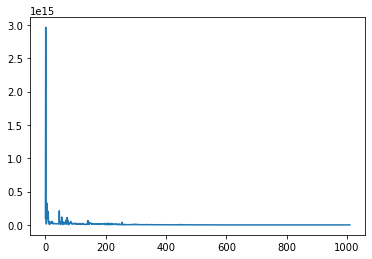

In [132]:
plt.plot(losses)

In [ ]:
## choose anomalies based on validation / test set 

In [ ]:
#zero out each value, see output of the model... see which outputs are highest 

In [93]:
#sklearn train-test split
# zero ou


In [ ]:

one_hot = np.identity(1024) 
ic = np.zeros((len(data),1024))
for i in tqdm(range(len(data))): # for all examples in dataset
    for j in range(1024): # for all indexes of latent vector
        with torch.no_grad():
            inpt = torch.tensor(data[i] * one_hot[j], dtype=torch.float)#zero out all but one i from latent vec
            inpt = inpt.to(device)
            out = model(inpt).item()
            ic[i,j] = 1 - my_loss(out, labels[i]) # compute r^2
                   

 44%|█████████████████████████████████████████████████████████████████▊                                                                                   | 1131/2559 [4:53:30<2:45:19,  6.95s/it]